In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from binance.client import Client
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

# Import API keys from config
from config import BINANCE_API_KEY, BINANCE_API_SECRET
    
# Initialize Binance client
client = Client(BINANCE_API_KEY, BINANCE_API_SECRET)
print("Binance client initialized successfully")

Binance client initialized successfully


In [2]:
def get_top_50_crypto_assets():
    """
    Get the top 50 largest cryptocurrency assets by 24hr volume from Binance.
    
    Returns:
        pandas.DataFrame: DataFrame containing symbol, price, volume, and other metrics
    """
    try:
        # Get 24hr ticker statistics for all symbols
        tickers = client.get_ticker()
        
        # Convert to DataFrame
        df = pd.DataFrame(tickers)
        
        # Filter for USDT pairs only (most liquid and representative)
        usdt_pairs = df[df['symbol'].str.endswith('USDT')].copy()
        
        # Convert numeric columns
        numeric_cols = ['priceChange', 'priceChangePercent', 'weightedAvgPrice', 
                       'prevClosePrice', 'lastPrice', 'bidPrice', 'askPrice', 
                       'openPrice', 'highPrice', 'lowPrice', 'volume', 'quoteVolume']
        
        for col in numeric_cols:
            if col in usdt_pairs.columns:
                usdt_pairs[col] = pd.to_numeric(usdt_pairs[col], errors='coerce')
        
        # Sort by quote volume (USD volume) and get top 50
        top_50 = usdt_pairs.nlargest(50, 'quoteVolume').copy()
        
        # Add a clean symbol name (remove USDT suffix)
        top_50['base_asset'] = top_50['symbol'].str.replace('USDT', '')
        
        # Select relevant columns
        result_df = top_50[['symbol', 'base_asset', 'lastPrice', 'priceChangePercent', 
                           'volume', 'quoteVolume', 'highPrice', 'lowPrice']].copy()
        
        # Rename columns for clarity
        result_df.columns = ['Symbol', 'Base_Asset', 'Last_Price', 'Price_Change_24h_Pct', 
                            'Volume_24h', 'Quote_Volume_24h_USD', 'High_24h', 'Low_24h']
        
        # Reset index
        result_df.reset_index(drop=True, inplace=True)
        
        print(f"Successfully retrieved top 50 crypto assets by 24hr volume")
        print(f"Total quote volume (USD): ${result_df['Quote_Volume_24h_USD'].sum():,.0f}")
        
        return result_df
        
    except Exception as e:
        print(f"Error retrieving top crypto assets: {e}")
        return pd.DataFrame()

# Test the function
top_50_crypto = get_top_50_crypto_assets()
print(f"\nTop 10 crypto assets by volume:")
print(top_50_crypto.head(10)[['Symbol', 'Base_Asset', 'Last_Price', 'Quote_Volume_24h_USD']])

Successfully retrieved top 50 crypto assets by 24hr volume
Total quote volume (USD): $2,623,612,221

Top 10 crypto assets by volume:
      Symbol Base_Asset     Last_Price  Quote_Volume_24h_USD
0    BTCUSDT        BTC  107986.760000          3.680854e+08
1    ETHUSDT        ETH    2450.300000          3.599143e+08
2    SOLUSDT        SOL     151.230000          3.296252e+08
3   USDCUSDT       USDC       0.999700          2.407986e+08
4  PENGUUSDT      PENGU       0.013411          1.027583e+08
5  FDUSDUSDT      FDUSD       0.998000          9.602942e+07
6    XRPUSDT        XRP       2.190400          8.791883e+07
7    SUIUSDT        SUI       2.825300          7.573964e+07
8    SEIUSDT        SEI       0.307600          7.386467e+07
9   PEPEUSDT       PEPE       0.000010          6.012989e+07


In [3]:
def get_crypto_kline_data(symbol, interval='1d', lookback_days=365):
    """
    Get historical kline (candlestick) data for a cryptocurrency from Binance.
    
    Parameters:
        symbol (str): Trading pair symbol (e.g., 'BTCUSDT')
        interval (str): Kline interval ('1m', '5m', '15m', '30m', '1h', '4h', '1d', '1w', '1M')
        lookback_days (int): Number of days to look back from current date
        limit (int): Maximum number of klines to return (max 1000)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data and timestamps
    """
    try:
        # Calculate start time
        end_time = datetime.now()
        start_time = end_time - timedelta(days=lookback_days)
        
        # Convert to timestamp strings
        start_str = str(int(start_time.timestamp() * 1000))
        end_str = str(int(end_time.timestamp() * 1000))
        
        # Get kline data
        klines = client.get_historical_klines(
            symbol=symbol,
            interval=interval,
            start_str=start_str,
            end_str=end_str,
        )
        
        if not klines:
            print(f"No data found for {symbol}")
            return pd.DataFrame()
        
        # Convert to DataFrame
        df = pd.DataFrame(klines, columns=[
            'Open_time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close_time', 'Quote_asset_volume', 'Number_of_trades',
            'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'
        ])
        
        # Convert timestamp to datetime
        df['Date'] = pd.to_datetime(df['Open_time'], unit='ms')
        df['Close_Date'] = pd.to_datetime(df['Close_time'], unit='ms')
        
        # Convert price and volume columns to numeric
        price_volume_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote_asset_volume']
        for col in price_volume_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Select and reorder columns
        final_df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Quote_asset_volume']].copy()
        
        # Add symbol information
        final_df['Symbol'] = symbol
        final_df['Base_Asset'] = symbol.replace('USDT', '') if symbol.endswith('USDT') else symbol
        
        # Sort by date
        final_df.sort_values('Date', inplace=True)
        final_df.reset_index(drop=True, inplace=True)
        
        print(f"Retrieved {len(final_df)} klines for {symbol} ({interval} interval)")
        print(f"Date range: {final_df['Date'].min().date()} to {final_df['Date'].max().date()}")
        
        return final_df
        
    except Exception as e:
        print(f"Error retrieving kline data for {symbol}: {e}")
        return pd.DataFrame()

# Test the function with Bitcoin
btc_data = get_crypto_kline_data('BTCUSDT', interval='1d', lookback_days=2000)
print(f"\nBTC data preview:")
print(btc_data.head())

Retrieved 2000 klines for BTCUSDT (1d interval)
Date range: 2020-01-08 to 2025-06-29

BTC data preview:
        Date     Open     High      Low    Close         Volume  \
0 2020-01-08  8145.92  8455.00  7870.00  8055.98  112622.642640   
1 2020-01-09  8054.72  8055.96  7750.00  7817.76   64239.519830   
2 2020-01-10  7817.74  8199.00  7672.00  8197.02   82406.777448   
3 2020-01-11  8198.86  8286.34  8003.16  8020.01   54810.032667   
4 2020-01-12  8020.01  8197.00  7960.00  8184.98   38131.494336   

   Quote_asset_volume   Symbol Base_Asset  
0        9.264102e+08  BTCUSDT        BTC  
1        5.072583e+08  BTCUSDT        BTC  
2        6.527742e+08  BTCUSDT        BTC  
3        4.450343e+08  BTCUSDT        BTC  
4        3.093519e+08  BTCUSDT        BTC  


In [5]:
def get_multiple_crypto_data(symbols_list, interval='1d', lookback_days=365, delay=0.1):
    """
    Get historical kline data for multiple cryptocurrency symbols.
    
    Parameters:
        symbols_list (list): List of trading pair symbols
        interval (str): Kline interval
        lookback_days (int): Number of days to look back
        delay (float): Delay between API calls in seconds to avoid rate limits
    
    Returns:
        dict: Dictionary with symbol as key and DataFrame as value
    """
    crypto_data = {}
    failed_symbols = []
    
    print(f"Fetching historical data for {len(symbols_list)} crypto assets...")
    print(f"Interval: {interval}, Lookback: {lookback_days} days")
    print("-" * 60)
    
    for i, symbol in enumerate(symbols_list, 1):
        try:
            print(f"[{i}/{len(symbols_list)}] Fetching {symbol}...", end=" ")
            
            # Get the data
            df = get_crypto_kline_data(
                symbol=symbol, 
                interval=interval, 
                lookback_days=lookback_days
            )
            
            if not df.empty:
                crypto_data[symbol] = df
                print("✓ Success")
            else:
                failed_symbols.append(symbol)
                print("✗ No data")
            
            # Rate limiting delay
            if delay > 0:
                time.sleep(delay)
                
        except Exception as e:
            failed_symbols.append(symbol)
            print(f"✗ Error: {e}")
            
        # Add a longer delay every 10 requests to be safe with rate limits
        if i % 10 == 0:
            print(f"Processed {i} symbols. Waiting 2 seconds...")
            time.sleep(2)
    
    print("-" * 60)
    print(f"Successfully retrieved data for {len(crypto_data)} out of {len(symbols_list)} symbols")
    
    if failed_symbols:
        print(f"Failed symbols: {failed_symbols}")
    
    return crypto_data

# Example: Get historical data for top 10 crypto assets
if not top_50_crypto.empty:
    top_10_symbols = top_50_crypto['Symbol'].tolist()
    print(f"Getting historical data for top 10 crypto assets:")
    print(top_10_symbols)
    
    # Get the data (using smaller lookback for demo)
    crypto_historical_data = get_multiple_crypto_data(
        symbols_list=top_10_symbols,
        interval='1d',
        lookback_days=2000,  # Last 30 days for demo
        delay=0.1  # 200ms delay between requests
    )
    
    # Display summary
    print(f"\nData Summary:")
    for symbol, df in crypto_historical_data.items():
        if not df.empty:
            latest_price = df['Close'].iloc[-1]
            price_change = ((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100
            print(f"{symbol}: {len(df)} days, Latest: ${latest_price:.2f}, Change: {price_change:.2f}%")
else:
    print("Please run the previous cell to get top 50 crypto assets first.")

Getting historical data for top 10 crypto assets:
['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'USDCUSDT', 'PENGUUSDT', 'FDUSDUSDT', 'XRPUSDT', 'SUIUSDT', 'SEIUSDT', 'PEPEUSDT', 'SAHARAUSDT', 'NEWTUSDT', 'TRXUSDT', 'UNIUSDT', 'DOGEUSDT', 'BNBUSDT', 'WIFUSDT', 'BANANAS31USDT', 'SYRUPUSDT', 'ADAUSDT', 'PNUTUSDT', 'LPTUSDT', 'VIRTUALUSDT', 'NEIROUSDT', 'FUNUSDT', 'WUSDT', 'AAVEUSDT', 'APTUSDT', 'LTCUSDT', 'ENAUSDT', 'AVAXUSDT', 'BCHUSDT', 'TRUMPUSDT', 'LINKUSDT', 'BROCCOLI714USDT', 'BONKUSDT', 'RESOLVUSDT', '1000CATUSDT', 'WLDUSDT', 'MUBARAKUSDT', 'NEARUSDT', 'TAOUSDT', 'KAITOUSDT', 'HBARUSDT', 'ARBUSDT', 'BSWUSDT', 'JTOUSDT', 'CTKUSDT', 'FETUSDT', 'OMUSDT']
Fetching historical data for 50 crypto assets...
Interval: 1d, Lookback: 2000 days
------------------------------------------------------------
[1/50] Fetching BTCUSDT... Retrieved 2000 klines for BTCUSDT (1d interval)
Date range: 2020-01-08 to 2025-06-29
✓ Success
[2/50] Fetching ETHUSDT... Retrieved 2000 klines for ETHUSDT (1d interval)
Date r

Retrieved 195 klines for PENGUUSDT (1d interval)
Date range: 2024-12-17 to 2025-06-29
✓ Success
[6/50] Fetching FDUSDUSDT... Retrieved 705 klines for FDUSDUSDT (1d interval)
Date range: 2023-07-26 to 2025-06-29
✓ Success
[7/50] Fetching XRPUSDT... Retrieved 2000 klines for XRPUSDT (1d interval)
Date range: 2020-01-08 to 2025-06-29
✓ Success
[8/50] Fetching SUIUSDT... Retrieved 789 klines for SUIUSDT (1d interval)
Date range: 2023-05-03 to 2025-06-29
✓ Success
[9/50] Fetching SEIUSDT... Retrieved 685 klines for SEIUSDT (1d interval)
Date range: 2023-08-15 to 2025-06-29
✓ Success
[10/50] Fetching PEPEUSDT... Retrieved 787 klines for PEPEUSDT (1d interval)
Date range: 2023-05-05 to 2025-06-29
✓ Success
Processed 10 symbols. Waiting 2 seconds...
[11/50] Fetching SAHARAUSDT... Retrieved 4 klines for SAHARAUSDT (1d interval)
Date range: 2025-06-26 to 2025-06-29
✓ Success
[12/50] Fetching NEWTUSDT... Retrieved 6 klines for NEWTUSDT (1d interval)
Date range: 2025-06-24 to 2025-06-29
✓ Success


In [6]:
df

,Date,Open,High,Low,Close,Volume,Quote_asset_volume,Symbol,Base_Asset
0,2021-03-08,0.2818,0.5834,0.2818,0.4335,1.701652e+08,7.849085e+07,OMUSDT,OM
1,2021-03-09,0.4343,0.4400,0.3653,0.4015,5.299571e+07,2.122173e+07,OMUSDT,OM
2,2021-03-10,0.4018,0.4095,0.3449,0.3466,1.715859e+07,6.395666e+06,OMUSDT,OM
3,2021-03-11,0.3459,0.3880,0.3301,0.3800,1.907308e+07,6.894997e+06,OMUSDT,OM
4,2021-03-12,0.3796,0.4250,0.3513,0.3789,1.895610e+07,7.399092e+06,OMUSDT,OM
...,...,...,...,...,...,...,...,...,...
1570,2025-06-25,0.2210,0.2217,0.2077,0.2103,2.667438e+07,5.737028e+06,OMUSDT,OM
1571,2025-06-26,0.2103,0.2145,0.1970,0.2007,2.457628e+07,5.019654e+06,OMUSDT,OM
1572,2025-06-27,0.2008,0.2070,0.1988,0.2050,2.437640e+07,4.935993e+06,OMUSDT,OM
1573,2025-06-28,0.2051,0.2110,0.2009,0.2085,1.445890e+07,2.972011e+06,OMUSDT,OM


In [7]:
# Show available symbols and the number of rows for each
summary = pd.DataFrame({
	'Symbol': list(crypto_historical_data.keys()),
	'Rows': [df.shape[0] for df in crypto_historical_data.values()],
	'Columns': [df.shape[1] for df in crypto_historical_data.values()]
})
summary

,Symbol,Rows,Columns
0,BTCUSDT,2000,9
1,ETHUSDT,2000,9
2,SOLUSDT,1784,9
3,USDCUSDT,1835,9
4,PENGUUSDT,195,9
5,FDUSDUSDT,705,9
6,XRPUSDT,2000,9
7,SUIUSDT,789,9
8,SEIUSDT,685,9
9,PEPEUSDT,787,9


In [8]:
def combine_crypto_data(crypto_data_dict, price_column='Close'):
    """
    Combine multiple crypto DataFrames into a single DataFrame with symbols as columns.
    
    Parameters:
        crypto_data_dict (dict): Dictionary of symbol -> DataFrame
        price_column (str): Which price column to use ('Open', 'High', 'Low', 'Close')
    
    Returns:
        pandas.DataFrame: Combined DataFrame with Date as index and symbols as columns
    """
    if not crypto_data_dict:
        print("No data to combine")
        return pd.DataFrame()
    
    combined_data = {}
    
    for symbol, df in crypto_data_dict.items():
        if not df.empty and price_column in df.columns:
            # Use Date as index and the specified price column as values
            temp_df = df.set_index('Date')[price_column]
            combined_data[symbol] = temp_df
    
    if combined_data:
        result_df = pd.DataFrame(combined_data)
        result_df.index.name = 'Date'
        
        print(f"Combined data shape: {result_df.shape}")
        print(f"Date range: {result_df.index.min().date()} to {result_df.index.max().date()}")
        
        return result_df
    else:
        print("No valid data to combine")
        return pd.DataFrame()

def export_crypto_data(crypto_data_dict, filename_prefix='crypto_data'):
    """
    Export crypto data to CSV files.
    
    Parameters:
        crypto_data_dict (dict): Dictionary of symbol -> DataFrame
        filename_prefix (str): Prefix for the output files
    """
    if not crypto_data_dict:
        print("No data to export")
        return
    
    # Export individual symbol data
    for symbol, df in crypto_data_dict.items():
        if not df.empty:
            filename = f"{filename_prefix}_{symbol}.csv"
            df.to_csv(filename, index=False)
            print(f"Exported {symbol} data to {filename}")
    
    # Export combined data
    combined_df = combine_crypto_data(crypto_data_dict)
    if not combined_df.empty:
        combined_filename = f"{filename_prefix}_combined_close.csv"
        combined_df.to_csv(combined_filename)
        print(f"Exported combined close prices to {combined_filename}")

# Example usage and data analysis
if 'crypto_historical_data' in locals() and crypto_historical_data:
    print("=== DATA ANALYSIS EXAMPLES ===")
    
    # 1. Combine close prices
    combined_prices = combine_crypto_data(crypto_historical_data, 'Close')
    if not combined_prices.empty:
        print(f"\nCombined close prices preview:")
        print(combined_prices.tail())
        
        # 2. Calculate correlations
        correlations = combined_prices.corr()
        print(f"\nCorrelation matrix (top 5x5):")
        print(correlations.iloc[:5, :5].round(3))
        
        # 3. Calculate daily returns
        daily_returns = combined_prices.pct_change().dropna()
        print(f"\nDaily returns statistics:")
        print(daily_returns.describe().round(4))
        
        # 4. Volatility analysis
        volatility = daily_returns.std() * np.sqrt(365)  # Annualized volatility
        print(f"\nAnnualized volatility (sorted):")
        print(volatility.sort_values(ascending=False).round(4))
        
    print(f"\n=== EXPORT OPTIONS ===")
    print("To export the data, run:")
    print("export_crypto_data(crypto_historical_data, 'my_crypto_analysis')")
else:
    print("No crypto data available. Please run the previous cells first.")

=== DATA ANALYSIS EXAMPLES ===
Combined data shape: (2000, 50)
Date range: 2020-01-08 to 2025-06-29

Combined close prices preview:
              BTCUSDT  ETHUSDT  SOLUSDT  USDCUSDT  PENGUUSDT  FDUSDUSDT  \
Date                                                                      
2025-06-25  107340.58  2418.49   143.57    0.9995   0.009673     0.9983   
2025-06-26  106947.06  2415.96   139.06    0.9995   0.009186     0.9981   
2025-06-27  107047.59  2423.17   142.09    0.9996   0.010753     0.9980   
2025-06-28  107296.79  2435.62   150.72    0.9996   0.013911     0.9979   
2025-06-29  107986.75  2450.25   151.23    0.9997   0.013404     0.9980   

            XRPUSDT  SUIUSDT  SEIUSDT  PEPEUSDT  ...  NEARUSDT  TAOUSDT  \
Date                                             ...                      
2025-06-25   2.1859   2.7316   0.2798  0.000009  ...     2.139    323.3   
2025-06-26   2.1054   2.6012   0.2562  0.000009  ...     2.050    319.7   
2025-06-27   2.1419   2.7213   0.2894  0.0

In [9]:
# Compute the correlation matrix for daily returns
corr_matrix = daily_returns.corr()

# Unstack the matrix, drop self-correlations and duplicate pairs
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.drop_duplicates().sort_values(ascending=False)

# Show the top 10 most correlated pairs
print("Top 10 most correlated asset pairs:")
print(corr_pairs.head(10))

# Show the top 10 least correlated pairs
print("\nTop 10 least correlated asset pairs:")
print(corr_pairs.tail(10))

Top 10 most correlated asset pairs:
PEPEUSDT         1000CATUSDT        1.000000
WIFUSDT          BROCCOLI714USDT    0.999998
PENGUUSDT        NEIROUSDT          0.999948
ADAUSDT          MUBARAKUSDT        0.999947
BONKUSDT         ARBUSDT            0.999913
LINKUSDT         BONKUSDT           0.999879
BROCCOLI714USDT  ARBUSDT            0.999750
KAITOUSDT        JTOUSDT            0.999723
WIFUSDT          ARBUSDT            0.999703
NEWTUSDT         TAOUSDT            0.999690
dtype: float64

Top 10 least correlated asset pairs:
WIFUSDT        LPTUSDT           -0.999706
USDCUSDT       JTOUSDT           -0.999711
LPTUSDT        BROCCOLI714USDT   -0.999753
NEIROUSDT      TAOUSDT           -0.999855
BANANAS31USDT  VIRTUALUSDT       -0.999888
LPTUSDT        BONKUSDT          -0.999911
USDCUSDT       PEPEUSDT          -0.999998
               1000CATUSDT       -0.999998
BTCUSDT        BNBUSDT           -1.000000
LPTUSDT        ARBUSDT           -1.000000
dtype: float64


In [ ]:
# Get volume data and normalize each symbol independently
volumes = combine_crypto_data(crypto_historical_data, 'Volume')

# Normalize each symbol's volume independently (column-wise normalization)
# This prevents symbols with large volumes from dominating the analysis
normalized_volumes = volumes.copy()

for symbol in volumes.columns:
    symbol_volumes = volumes[symbol].dropna()
    if len(symbol_volumes) > 0:
        # Min-max normalization for each symbol independently
        min_vol = symbol_volumes.min()
        max_vol = symbol_volumes.max()
        
        if max_vol > min_vol:  # Avoid division by zero
            normalized_volumes[symbol] = (volumes[symbol] - min_vol) / (max_vol - min_vol)
        else:
            normalized_volumes[symbol] = 0  # All values are the same

print("Volume normalization completed - each symbol normalized independently")
print(f"Original volume ranges:")
for symbol in volumes.columns:
    symbol_volumes = volumes[symbol].dropna()
    if len(symbol_volumes) > 0:
        print(f"  {symbol}: {symbol_volumes.min():,.0f} to {symbol_volumes.max():,.0f}")

print(f"\nNormalized volumes (all should be 0.0 to 1.0):")
for symbol in normalized_volumes.columns:
    symbol_normalized = normalized_volumes[symbol].dropna()
    if len(symbol_normalized) > 0:
        print(f"  {symbol}: {symbol_normalized.min():.3f} to {symbol_normalized.max():.3f}")

normalized_volumes

Combined data shape: (2000, 50)
Date range: 2020-01-08 to 2025-06-29


,BTCUSDT,ETHUSDT,SOLUSDT,USDCUSDT,PENGUUSDT,FDUSDUSDT,XRPUSDT,SUIUSDT,SEIUSDT,PEPEUSDT,...,NEARUSDT,TAOUSDT,KAITOUSDT,HBARUSDT,ARBUSDT,BSWUSDT,JTOUSDT,CTKUSDT,FETUSDT,OMUSDT
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08,0.146208,0.111179,NaN,0.001849,NaN,NaN,0.015976,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003924,NaN,NaN,NaN,NaN,0.060339,NaN
2020-01-09,0.082468,0.066792,NaN,0.000386,NaN,NaN,0.007442,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003423,NaN,NaN,NaN,NaN,0.055742,NaN
2020-01-10,0.106402,0.076201,NaN,0.002357,NaN,NaN,0.015553,NaN,NaN,NaN,...,NaN,NaN,NaN,0.005638,NaN,NaN,NaN,NaN,0.018759,NaN
2020-01-11,0.070045,0.067286,NaN,0.000337,NaN,NaN,0.012530,NaN,NaN,NaN,...,NaN,NaN,NaN,0.004415,NaN,NaN,NaN,NaN,0.099001,NaN
2020-01-12,0.048073,0.037141,NaN,0.000019,NaN,NaN,0.006886,NaN,NaN,NaN,...,NaN,NaN,NaN,0.001535,NaN,NaN,NaN,NaN,0.113775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-25,0.019840,0.077393,0.050881,0.237477,0.150825,0.060124,0.009313,0.099284,0.500649,0.051527,...,0.090124,0.148524,0.005076,0.018180,0.137264,0.022878,0.002692,0.093515,0.039996,0.026018
2025-06-26,0.011767,0.087993,0.059258,0.259034,0.110662,0.049337,0.012663,0.110063,0.278429,0.049917,...,0.124221,0.120256,0.001973,0.028073,0.126499,1.000000,0.001727,0.172627,0.039682,0.023907
2025-06-27,0.013953,0.070136,0.057789,0.305732,0.218288,0.059284,0.012686,0.115464,0.351224,0.035819,...,0.109886,0.080160,0.000871,0.018401,0.093833,0.257821,0.000000,0.043542,0.043020,0.023706


In [ ]:
# Analyze trading volume by day of the week using normalized data
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_volume_by_weekday_normalized(crypto_data_dict, use_normalized=True):
    """
    Analyze which day of the week has the highest average trading volume
    Uses normalized volumes to prevent large volume symbols from dominating
    
    Parameters:
        crypto_data_dict (dict): Dictionary of symbol -> DataFrame
        use_normalized (bool): Whether to normalize each symbol's volume independently
    
    Returns:
        pandas.DataFrame: Summary of volume statistics by weekday
    """
    all_volume_data = []
    
    # Collect volume data from all cryptocurrencies
    for symbol, df in crypto_data_dict.items():
        if not df.empty and 'Volume' in df.columns:
            temp_df = df[['Date', 'Volume']].copy()
            temp_df['Symbol'] = symbol
            temp_df['Weekday'] = temp_df['Date'].dt.day_name()
            temp_df['Weekday_num'] = temp_df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
            
            # Normalize volume for this symbol if requested
            if use_normalized:
                symbol_volumes = temp_df['Volume']
                min_vol = symbol_volumes.min()
                max_vol = symbol_volumes.max()
                
                if max_vol > min_vol:
                    temp_df['Volume'] = (symbol_volumes - min_vol) / (max_vol - min_vol)
                else:
                    temp_df['Volume'] = 0.5  # Neutral value if all volumes are the same
            
            all_volume_data.append(temp_df)
    
    if not all_volume_data:
        print("No volume data available")
        return pd.DataFrame(), pd.DataFrame()
    
    # Combine all volume data
    combined_volume_df = pd.concat(all_volume_data, ignore_index=True)
    
    # Calculate statistics by weekday
    weekday_stats = combined_volume_df.groupby('Weekday')['Volume'].agg([
        'count', 'mean', 'median', 'std', 'sum'
    ]).round(4)
    
    # Reorder by weekday (Monday to Sunday)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = weekday_stats.reindex(weekday_order)
    
    # Add percentage of total volume
    weekday_stats['pct_of_total'] = (weekday_stats['sum'] / weekday_stats['sum'].sum() * 100).round(2)
    
    return weekday_stats, combined_volume_df

# Perform the analysis with normalized volumes
if 'crypto_historical_data' in locals() and crypto_historical_data:
    print("=== NORMALIZED VOLUME ANALYSIS BY DAY OF WEEK ===")
    print("(Each symbol's volume is normalized independently to prevent bias)")
    
    weekday_stats_norm, volume_df_norm = analyze_volume_by_weekday_normalized(crypto_historical_data, use_normalized=True)
    
    if not weekday_stats_norm.empty:
        print("\nNormalized Volume Statistics by Weekday:")
        print(weekday_stats_norm)
        
        # Find the day with highest average volume
        highest_avg_day = weekday_stats_norm['mean'].idxmax()
        highest_avg_volume = weekday_stats_norm['mean'].max()
        
        print(f"\n🏆 HIGHEST AVERAGE NORMALIZED VOLUME DAY: {highest_avg_day}")
        print(f"Average Normalized Volume: {highest_avg_volume:.4f}")
        
        # Show top 3 days by different metrics
        print(f"\nTop 3 days by average normalized volume:")
        top_avg = weekday_stats_norm['mean'].sort_values(ascending=False).head(3)
        for i, (day, vol) in enumerate(top_avg.items(), 1):
            print(f"{i}. {day}: {vol:.4f}")
        
        print(f"\nTop 3 days by total normalized volume:")
        top_total = weekday_stats_norm['sum'].sort_values(ascending=False).head(3)
        for i, (day, vol) in enumerate(top_total.items(), 1):
            print(f"{i}. {day}: {vol:.4f}")
            
        print(f"\nNormalized volume distribution (% of total):")
        for day, pct in weekday_stats_norm['pct_of_total'].items():
            print(f"{day}: {pct}%")

    # Also run analysis with raw volumes for comparison
    print(f"\n" + "="*60)
    print("=== RAW VOLUME ANALYSIS (for comparison) ===")
    
    weekday_stats_raw, volume_df_raw = analyze_volume_by_weekday_normalized(crypto_historical_data, use_normalized=False)
    
    if not weekday_stats_raw.empty:
        print(f"\nComparison - Raw vs Normalized highest volume days:")
        raw_highest = weekday_stats_raw['mean'].idxmax()
        norm_highest = weekday_stats_norm['mean'].idxmax()
        
        print(f"Raw volumes highest day: {raw_highest}")
        print(f"Normalized volumes highest day: {norm_highest}")
        
        if raw_highest != norm_highest:
            print(f"⚠️  Different results! Large volume symbols were skewing the raw analysis.")
        else:
            print(f"✅ Same result with both methods - pattern is consistent across symbols.")

else:
    print("Please run the previous cells to load crypto data first.")

=== VOLUME ANALYSIS BY DAY OF WEEK ===

Volume Statistics by Weekday:
           count          mean       median           std           sum  \
Weekday                                                                   
Monday      7488  5.792922e+11  12653426.96  5.784167e+12  4.337740e+15   
Tuesday     7497  5.839862e+11  12724559.67  6.095767e+12  4.378145e+15   
Wednesday   7517  5.782739e+11  12699897.30  6.260169e+12  4.346885e+15   
Thursday    7527  5.382183e+11  12374194.00  5.429416e+12  4.051169e+15   
Friday      7531  5.654839e+11  12185442.13  5.808774e+12  4.258659e+15   
Saturday    7532  4.183871e+11   9737821.03  4.550094e+12  3.151292e+15   
Sunday      7533  3.975025e+11  10053108.71  4.018947e+12  2.994386e+15   

           pct_of_total  
Weekday                  
Monday            15.76  
Tuesday           15.91  
Wednesday         15.80  
Thursday          14.72  
Friday            15.48  
Saturday          11.45  
Sunday            10.88  

🏆 HIGHEST AVERAGE V

In [19]:
volume_df

,Date,Volume,Symbol,Weekday,Weekday_num
0,2020-01-08,1.126226e+05,BTCUSDT,Wednesday,2
1,2020-01-09,6.423952e+04,BTCUSDT,Thursday,3
2,2020-01-10,8.240678e+04,BTCUSDT,Friday,4
3,2020-01-11,5.481003e+04,BTCUSDT,Saturday,5
4,2020-01-12,3.813149e+04,BTCUSDT,Sunday,6
...,...,...,...,...,...
52620,2025-06-25,2.667438e+07,OMUSDT,Wednesday,2
52621,2025-06-26,2.457628e+07,OMUSDT,Thursday,3
52622,2025-06-27,2.437640e+07,OMUSDT,Friday,4
52623,2025-06-28,1.445890e+07,OMUSDT,Saturday,5


In [17]:
weekday_stats

,count,mean,median,std,sum,pct_of_total
Weekday,,,,,,
Monday,7488,5.792922e+11,12653426.96,5.784167e+12,4.337740e+15,15.76
Tuesday,7497,5.839862e+11,12724559.67,6.095767e+12,4.378145e+15,15.91
Wednesday,7517,5.782739e+11,12699897.30,6.260169e+12,4.346885e+15,15.80
Thursday,7527,5.382183e+11,12374194.00,5.429416e+12,4.051169e+15,14.72
Friday,7531,5.654839e+11,12185442.13,5.808774e+12,4.258659e+15,15.48
Saturday,7532,4.183871e+11,9737821.03,4.550094e+12,3.151292e+15,11.45
Sunday,7533,3.975025e+11,10053108.71,4.018947e+12,2.994386e+15,10.88


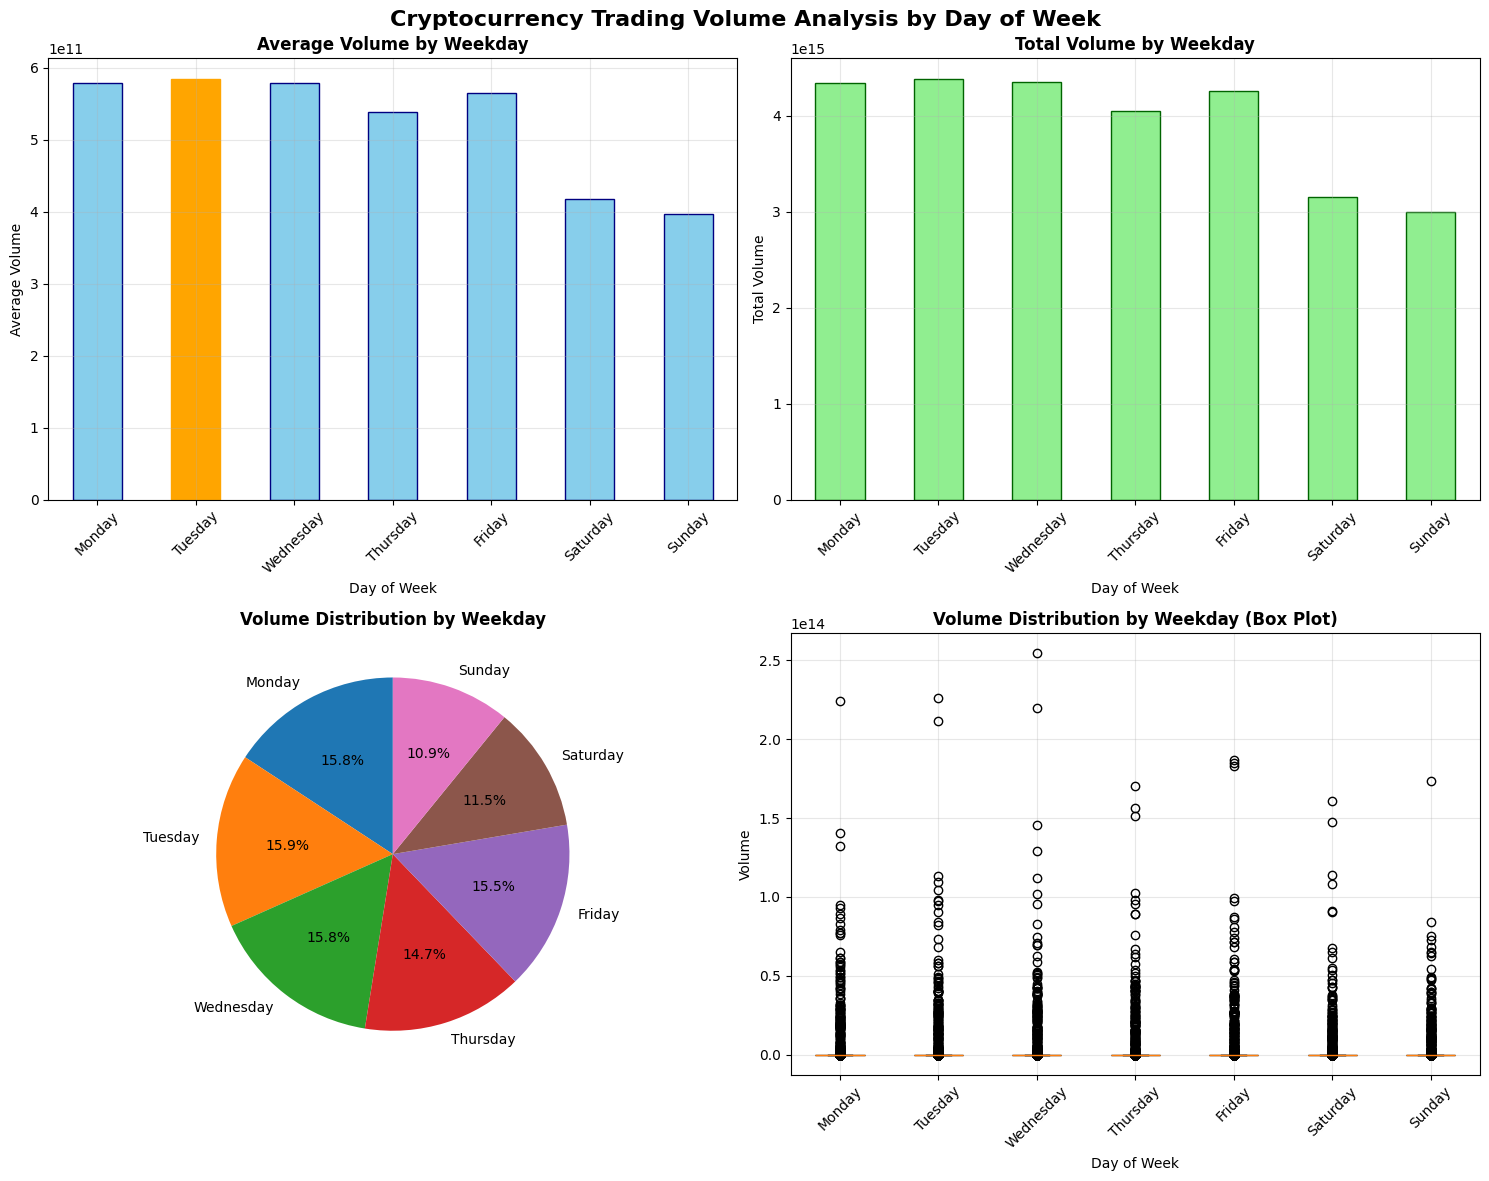

In [ ]:
# Create visualizations for normalized volume analysis by weekday
def plot_volume_by_weekday_normalized(weekday_stats_norm, volume_df_norm, weekday_stats_raw=None):
    """
    Create visualizations for normalized volume analysis by day of week
    """
    if weekday_stats_norm.empty:
        print("No data to plot")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    
    # Create subplots - add comparison if raw data is available
    if weekday_stats_raw is not None and not weekday_stats_raw.empty:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Cryptocurrency Trading Volume Analysis by Day of Week\n(Normalized vs Raw Volume Comparison)', 
                    fontsize=16, fontweight='bold')
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Cryptocurrency Trading Volume Analysis by Day of Week\n(Normalized Volumes)', 
                    fontsize=16, fontweight='bold')
    
    # 1. Average Normalized Volume by Weekday (Bar Plot)
    ax1 = axes[0, 0]
    weekday_stats_norm['mean'].plot(kind='bar', ax=ax1, color='skyblue', edgecolor='navy')
    ax1.set_title('Average Normalized Volume by Weekday', fontweight='bold')
    ax1.set_ylabel('Average Normalized Volume (0-1)')
    ax1.set_xlabel('Day of Week')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Highlight the highest day
    max_idx = weekday_stats_norm['mean'].argmax()
    ax1.patches[max_idx].set_color('orange')
    
    # 2. Total Normalized Volume by Weekday (Bar Plot)
    ax2 = axes[0, 1]
    weekday_stats_norm['sum'].plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='darkgreen')
    ax2.set_title('Total Normalized Volume by Weekday', fontweight='bold')
    ax2.set_ylabel('Total Normalized Volume')
    ax2.set_xlabel('Day of Week')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Normalized Volume Distribution (Pie Chart)
    ax3 = axes[1, 0]
    weekday_stats_norm['pct_of_total'].plot(kind='pie', ax=ax3, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Normalized Volume Distribution by Weekday', fontweight='bold')
    ax3.set_ylabel('')
    
    # 4. Box Plot of Normalized Volume Distribution
    ax4 = axes[1, 1]
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Prepare data for box plot
    box_data = []
    labels = []
    for day in weekday_order:
        day_volumes = volume_df_norm[volume_df_norm['Weekday'] == day]['Volume']
        if len(day_volumes) > 0:
            box_data.append(day_volumes)
            labels.append(day)
    
    if box_data:
        box_plot = ax4.boxplot(box_data, labels=labels, patch_artist=True)
        ax4.set_title('Normalized Volume Distribution by Weekday (Box Plot)', fontweight='bold')
        ax4.set_ylabel('Normalized Volume (0-1)')
        ax4.set_xlabel('Day of Week')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgray', 'lightcyan']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
    
    # If raw data is provided, add comparison charts
    if weekday_stats_raw is not None and not weekday_stats_raw.empty:
        # 5. Raw vs Normalized comparison
        ax5 = axes[0, 2]
        
        # Normalize the raw data for comparison (scale to 0-1 for visualization)
        raw_mean_scaled = weekday_stats_raw['mean'] / weekday_stats_raw['mean'].max()
        norm_mean = weekday_stats_norm['mean']
        
        x = range(len(weekday_order))
        width = 0.35
        
        ax5.bar([i - width/2 for i in x], [raw_mean_scaled[day] for day in weekday_order], 
               width, label='Raw (scaled)', color='lightcoral', alpha=0.7)
        ax5.bar([i + width/2 for i in x], [norm_mean[day] for day in weekday_order], 
               width, label='Normalized', color='lightblue', alpha=0.7)
        
        ax5.set_title('Raw vs Normalized Volume Comparison', fontweight='bold')
        ax5.set_ylabel('Scaled Volume (0-1)')
        ax5.set_xlabel('Day of Week')
        ax5.set_xticks(x)
        ax5.set_xticklabels([day[:3] for day in weekday_order])
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Difference analysis
        ax6 = axes[1, 2]
        
        # Calculate rank differences
        raw_ranks = weekday_stats_raw['mean'].rank(ascending=False)
        norm_ranks = weekday_stats_norm['mean'].rank(ascending=False)
        rank_diff = raw_ranks - norm_ranks
        
        colors_diff = ['red' if x > 0 else 'blue' if x < 0 else 'gray' for x in rank_diff]
        rank_diff.plot(kind='bar', ax=ax6, color=colors_diff)
        ax6.set_title('Rank Difference (Raw - Normalized)', fontweight='bold')
        ax6.set_ylabel('Rank Difference')
        ax6.set_xlabel('Day of Week')
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(True, alpha=0.3)
        ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Create the visualizations with normalized data
if 'weekday_stats_norm' in locals() and not weekday_stats_norm.empty:
    # Check if we have both normalized and raw data
    if 'weekday_stats_raw' in locals() and not weekday_stats_raw.empty:
        plot_volume_by_weekday_normalized(weekday_stats_norm, volume_df_norm, weekday_stats_raw)
    else:
        plot_volume_by_weekday_normalized(weekday_stats_norm, volume_df_norm)
else:
    print("Please run the previous cell first to generate normalized weekday statistics.")

In [16]:
# Analyze volume patterns by individual cryptocurrencies
def analyze_individual_crypto_weekday_patterns(crypto_data_dict):
    """
    Analyze weekday volume patterns for each individual cryptocurrency
    """
    print("=== INDIVIDUAL CRYPTOCURRENCY WEEKDAY PATTERNS ===")
    
    crypto_weekday_analysis = {}
    
    for symbol, df in crypto_data_dict.items():
        if not df.empty and 'Volume' in df.columns:
            # Add weekday information
            temp_df = df.copy()
            temp_df['Weekday'] = temp_df['Date'].dt.day_name()
            
            # Calculate average volume by weekday for this crypto
            weekday_avg = temp_df.groupby('Weekday')['Volume'].mean()
            
            # Reorder by weekday
            weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            weekday_avg = weekday_avg.reindex(weekday_order)
            
            # Find the day with highest average volume for this crypto
            highest_day = weekday_avg.idxmax()
            highest_volume = weekday_avg.max()
            
            crypto_weekday_analysis[symbol] = {
                'highest_day': highest_day,
                'highest_volume': highest_volume,
                'weekday_averages': weekday_avg
            }
            
            print(f"\n{symbol}:")
            print(f"  Highest volume day: {highest_day} ({highest_volume:,.2f})")
            print(f"  Weekday averages:")
            for day, vol in weekday_avg.items():
                indicator = "🏆" if day == highest_day else "  "
                print(f"    {indicator} {day}: {vol:,.2f}")
    
    # Summary across all cryptocurrencies
    print(f"\n=== SUMMARY ACROSS ALL CRYPTOCURRENCIES ===")
    
    # Count which day is highest for each crypto
    highest_days_count = {}
    for symbol, analysis in crypto_weekday_analysis.items():
        day = analysis['highest_day']
        highest_days_count[day] = highest_days_count.get(day, 0) + 1
    
    print(f"\nMost common highest volume day across all cryptos:")
    sorted_days = sorted(highest_days_count.items(), key=lambda x: x[1], reverse=True)
    for day, count in sorted_days:
        print(f"  {day}: {count} cryptocurrencies ({count/len(crypto_weekday_analysis)*100:.1f}%)")
    
    return crypto_weekday_analysis

# Run the individual analysis
if 'crypto_historical_data' in locals() and crypto_historical_data:
    individual_patterns = analyze_individual_crypto_weekday_patterns(crypto_historical_data)
else:
    print("Please run the previous cells to load crypto data first.")

# Additional insights
print(f"\n=== KEY INSIGHTS ===")
if 'weekday_stats' in locals() and not weekday_stats.empty:
    # Overall pattern
    overall_highest = weekday_stats['mean'].idxmax()
    print(f"📊 Overall highest average volume day: {overall_highest}")
    
    # Weekend vs Weekday comparison
    weekend_avg = weekday_stats.loc[['Saturday', 'Sunday'], 'mean'].mean()
    weekday_avg = weekday_stats.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'mean'].mean()
    
    print(f"📈 Average weekday volume: {weekday_avg:,.2f}")
    print(f"📉 Average weekend volume: {weekend_avg:,.2f}")
    
    if weekday_avg > weekend_avg:
        diff_pct = ((weekday_avg - weekend_avg) / weekend_avg) * 100
        print(f"💡 Weekdays have {diff_pct:.1f}% higher volume than weekends")
    else:
        diff_pct = ((weekend_avg - weekday_avg) / weekday_avg) * 100
        print(f"💡 Weekends have {diff_pct:.1f}% higher volume than weekdays")
    
    # Most volatile day
    most_volatile_day = weekday_stats['std'].idxmax()
    print(f"📊 Most volatile volume day: {most_volatile_day}")
    
    # Most consistent day
    least_volatile_day = weekday_stats['std'].idxmin()
    print(f"📊 Most consistent volume day: {least_volatile_day}")

=== INDIVIDUAL CRYPTOCURRENCY WEEKDAY PATTERNS ===

BTCUSDT:
  Highest volume day: Wednesday (89,856.67)
  Weekday averages:
       Monday: 87,739.56
       Tuesday: 88,327.95
    🏆 Wednesday: 89,856.67
       Thursday: 87,866.37
       Friday: 88,124.18
       Saturday: 54,713.15
       Sunday: 57,419.15

ETHUSDT:
  Highest volume day: Monday (732,943.92)
  Weekday averages:
    🏆 Monday: 732,943.92
       Tuesday: 696,199.16
       Wednesday: 711,480.65
       Thursday: 703,896.89
       Friday: 678,314.08
       Saturday: 472,776.86
       Sunday: 510,456.95

SOLUSDT:
  Highest volume day: Wednesday (5,012,833.96)
  Weekday averages:
       Monday: 4,919,960.76
       Tuesday: 4,912,586.93
    🏆 Wednesday: 5,012,833.96
       Thursday: 4,833,697.40
       Friday: 4,695,196.29
       Saturday: 3,448,931.02
       Sunday: 3,537,936.75

USDCUSDT:
  Highest volume day: Monday (491,657,247.24)
  Weekday averages:
    🏆 Monday: 491,657,247.24
       Tuesday: 476,313,326.80
       Wednesda